In [106]:
!pip install pingouin
!pip install seaborn
!pip install joypy


In [107]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.miscmodels.ordinal_model import OrderedModel


# **Freedom in the World(2013-2025) Dataset Analysis**


In [108]:
# --- 1. Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 2. Load Dataset from Excel ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/content/drive/MyDrive/Freedom World.xlsx'
df = pd.read_excel(file_path, sheet_name='FIW(2013-2025)')

# --- 3. Basic Overview ---
print("\n=== First 5 Rows ===")
display(df.head())

print(f"Total rows: {df.shape[0]}")
print(f"Total columns: {df.shape[1]}")

# --- 4. Dataset Summary (Types & Missing Values) ---
df_summary = pd.DataFrame({
    "Column": df.columns,
    "Data Type": df.dtypes,
    "Non-Null Count": df.notnull().sum(),
    "Missing Values": df.isnull().sum()
})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== First 5 Rows ===


,Country/Territory,Region,C/T,Edition,Status,PR rating,CL rating,A1,A2,A3,...,F3,F4,F,G1,G2,G3,G4,G,CL,Total
0,Abkhazia,Eurasia,t,2025,PF,5,5,2,2,1,...,1,1,4,1,1,2,1,5,22,39
1,Afghanistan,Asia,c,2025,NF,7,7,0,0,0,...,0,0,0,0,1,0,1,2,5,6
2,Albania,Europe,c,2025,PF,3,3,3,3,3,...,2,3,10,3,2,2,2,9,40,68
3,Algeria,Africa,c,2025,NF,6,5,1,1,1,...,2,2,6,2,2,2,1,7,21,31
4,Andorra,Europe,c,2025,F,1,1,4,4,4,...,4,3,15,4,4,3,4,15,55,93


Total rows: 2723
Total columns: 44


In [109]:
# --- 5. Descriptive Statistics (Core Indicators) - Column-wise ---
core_cols = ['PR rating','CL rating','PR','CL','A','B','C','D','E','F','G','Total']
core_cols = [col for col in core_cols if col in df.columns]  # keep only existing

desc_core = df[core_cols].describe().round(2)

print("\n=== Descriptive Statistics (Core Indicators Only) ===")
display(desc_core)


=== Descriptive Statistics (Core Indicators Only) ===


,PR rating,CL rating,PR,CL,A,B,C,D,E,F,G,Total
count,2723.00,2723.00,2723.00,2723.00,2723.00,2723.00,2723.00,2723.00,2723.00,2723.00,2723.00,2723.00
mean,3.63,3.49,22.54,34.66,7.22,9.50,6.00,10.41,7.21,7.78,9.25,57.20
std,2.23,1.95,13.64,17.28,4.49,5.44,3.77,4.74,3.99,4.95,4.19,30.61
min,1.00,1.00,-3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.00
25%,1.00,2.00,10.00,20.00,3.00,4.00,3.00,7.00,4.00,4.00,6.00,29.50
50%,3.00,3.00,26.00,35.00,9.00,11.00,6.00,11.00,8.00,7.00,9.00,61.00
75%,6.00,5.00,36.00,51.00,12.00,15.00,9.00,15.00,11.00,12.00,13.00,86.50
max,7.00,7.00,40.00,60.00,12.00,16.00,12.00,16.00,12.00,16.00,16.00,100.00


In [110]:
# --- 6. Basic Counts ---
print("\n=== Basic Counts ===")
print(f"Unique Countries/Territories: {df['Country/Territory'].nunique()}")
print(f"Unique Regions: {df['Region'].nunique()}")
print("Regions List:", df['Region'].unique())
print(f"Unique Editions (Years): {df['Edition'].nunique()}")
print(f"Unique Status Categories: {df['Status'].nunique()}")
print("Status Categories:", df['Status'].unique())



=== Basic Counts ===
Unique Countries/Territories: 212
Unique Regions: 6
Regions List: ['Eurasia' 'Asia' 'Europe' 'Africa' 'Americas' 'Middle East']
Unique Editions (Years): 13
Unique Status Categories: 3
Status Categories: ['PF' 'NF' 'F']


In [111]:
# --- 7. Country Distribution by Status & Region
region_status_table = pd.crosstab(df['Region'], df['Status'], margins=False)
region_status_table['Total'] = region_status_table.sum(axis=1)
region_status_table.loc['Total'] = region_status_table.sum()

# Transpose to make Regions columns and Status rows
region_status_table = region_status_table.T

print("\n=== Country Distribution by Status & Region (Transposed) ===")
display(region_status_table)



=== Country Distribution by Status & Region (Transposed) ===


Region,Africa,Americas,Asia,Eurasia,Europe,Middle East,Total
Status,,,,,,,
F,125,301,222,0,470,13,1131
NF,315,33,141,139,8,152,788
PF,288,125,196,84,81,30,804
Total,728,459,559,223,559,195,2723


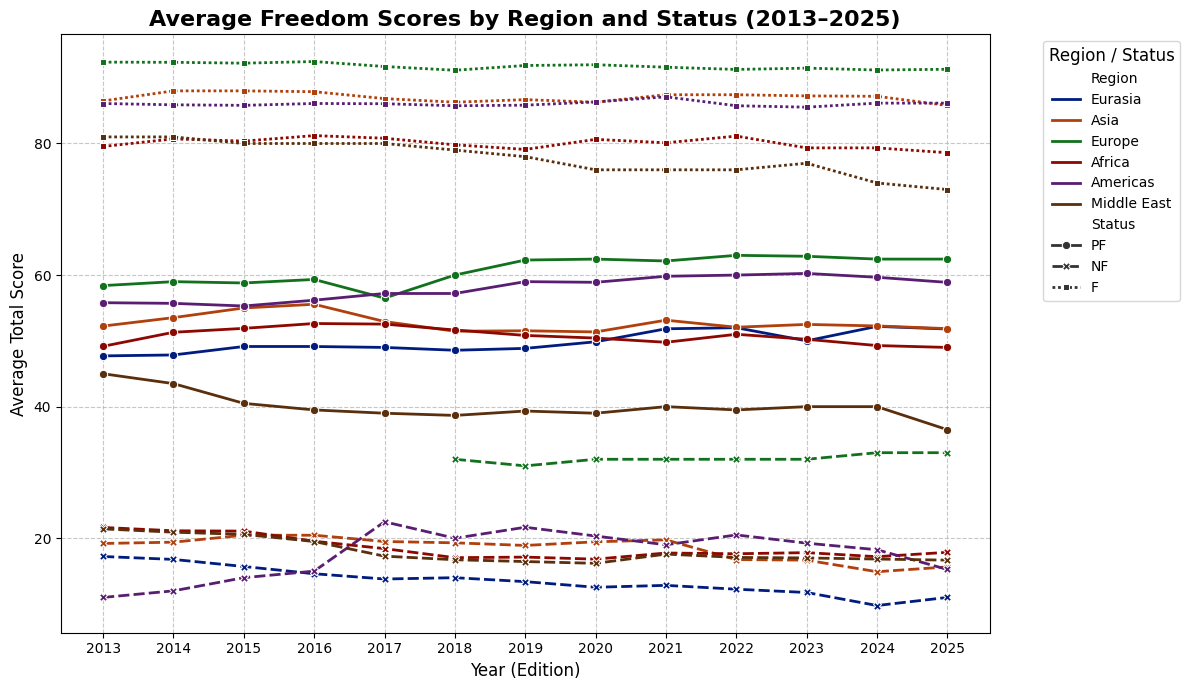

In [112]:
plt.figure(figsize=(12,7))
sns.lineplot(
    data=df,
    x='Edition',
    y='Total',
    hue='Region',
    style='Status',
    ci=None,
    markers=True,
    palette='dark',
    linewidth=2
)
plt.title('Average Freedom Scores by Region and Status (2013–2025)', fontsize=16, fontweight='bold')
plt.xlabel('Year (Edition)', fontsize=12)
plt.ylabel('Average Total Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Region / Status', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
# --- Force all editions to show on x-axis ---
plt.xticks(sorted(df['Edition'].unique()))  # 2013, 2014, ..., 2025

plt.tight_layout()
plt.show()


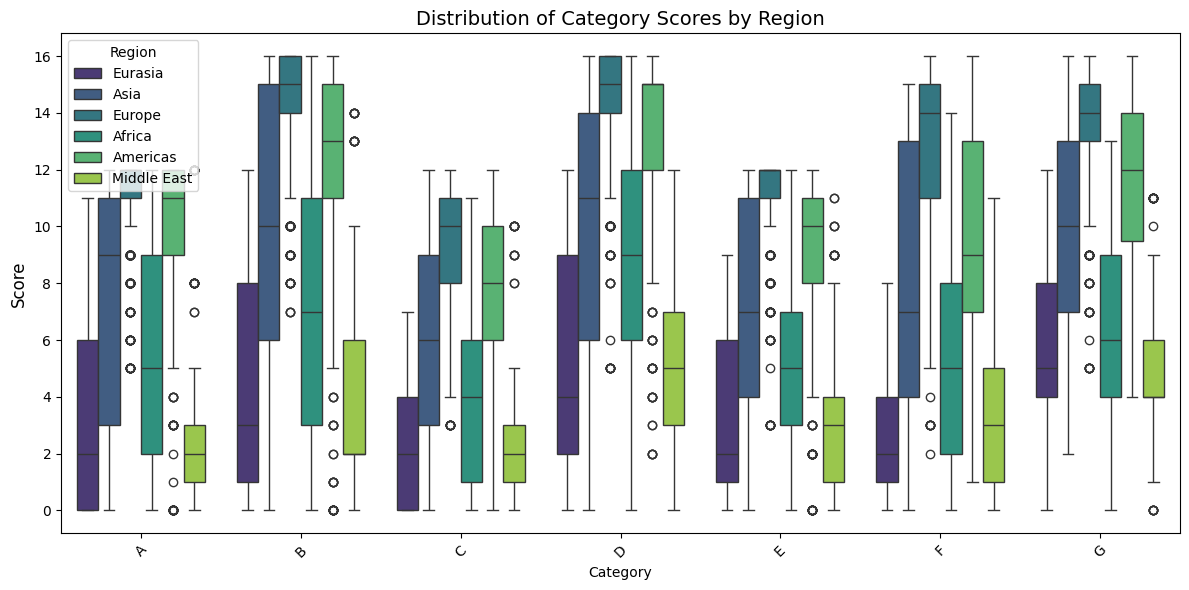

In [113]:

subcategories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
if all(col in df.columns for col in subcategories + ['Country/Territory', 'Region']):
    melt_df = df.melt(
        id_vars=['Country/Territory', 'Region'],
        value_vars=subcategories,
        var_name='Category',
        value_name='Score'
    )

    plt.figure(figsize=(12,6))
    sns.boxplot(data=melt_df, x='Category', y='Score', hue='Region', palette='viridis')
    plt.title('Distribution of Category Scores by Region', fontsize=14)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# **Data Enrichment**

In [114]:
# Step 1: Load manually enriched Freedom dataset (2013-2023)
df_freedom = pd.read_excel('/content/drive/MyDrive/Freedom World.xlsx', sheet_name='Freedom')

# Step 2: Clean column names
df_freedom.columns = df_freedom.columns.str.strip().str.replace('\xa0','')


In [115]:
# Step 3: Convert key columns to categorical
cat_cols = ['Country/Territory','C/T','Region','Status']
for col in cat_cols:
    if col in df_freedom.columns:
        df_freedom[col] = df_freedom[col].astype('category')


# Step 4: Handle missing values in the three added indicators
for col in ['Internet_Value','Female_LFPR','Tertiary_Enroll_Rate']:
    if col in df_freedom.columns:
        if df_freedom[col].skew() > 1:
            df_freedom[col].fillna(df_freedom[col].median(), inplace=True)
        else:
            df_freedom[col].fillna(df_freedom[col].mean(), inplace=True)

In [116]:
# Step 5: Descriptive statistics
desc_stats = df_freedom[['Internet Value','Female_LFPR','Tertiary_Enroll_Rate']].describe()
print(desc_stats)
# Show dataset shape
print("Freedom dataset shape:", df_freedom.shape)


       Internet Value  Female_LFPR  Tertiary_Enroll_Rate
count     2156.000000  2156.000000           2156.000000
mean        56.939096    56.825320             44.052853
std         28.398535    16.696509             27.175654
min          0.900000     5.130000              0.660000
25%         32.675000    50.057500             19.375000
50%         62.050000    58.910000             45.155000
75%         81.225000    68.797500             61.115000
max        100.000000    86.720000            166.670000
Freedom dataset shape: (2156, 47)


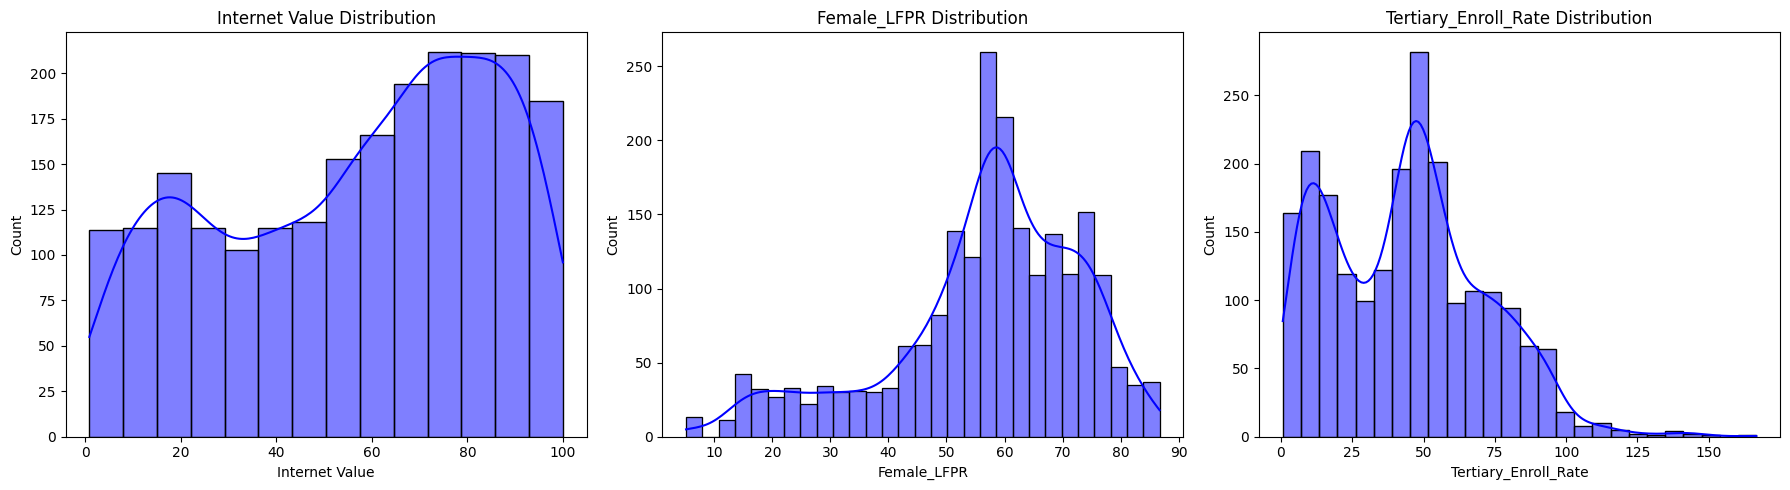

In [117]:
# Step 6: Visual inspection
cols = ['Internet Value','Female_LFPR','Tertiary_Enroll_Rate']

plt.figure(figsize=(18,5))

for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_freedom[col], kde=True, color='blue', edgecolor='black')
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()


# **Does Internet Penetration Enhance Freedom of Expression?**

**Data Preparation & Distribution**

Final sample size: 2156


,CL rating,Internet Value
count,2156.000000,2156.000000
mean,3.363636,56.939096
std,1.906505,28.398535
min,1.000000,0.900000
25%,2.000000,32.675000
50%,3.000000,62.050000
75%,5.000000,81.225000
max,7.000000,100.000000


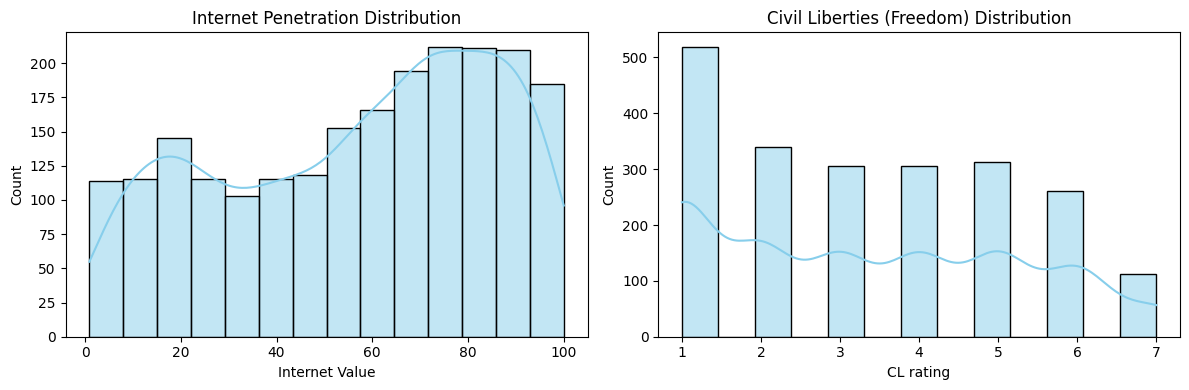

In [118]:
target = 'CL rating'
predictor = 'Internet Value'

data = df_freedom[[target, predictor]].dropna()

data[target] = pd.to_numeric(data[target], errors='coerce')
data[predictor] = pd.to_numeric(data[predictor], errors='coerce')
data = data.dropna()

print(f"Final sample size: {len(data)}")
display(data.describe())

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(data[predictor], kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Internet Penetration Distribution')
axes[0].set_xlabel(predictor)
sns.histplot(data[target], kde=True, color='skyblue', ax=axes[1])
axes[1].set_title('Civil Liberties (Freedom) Distribution')
axes[1].set_xlabel(target)
plt.tight_layout()
plt.show()

**Exploratory Relationship Analysis**

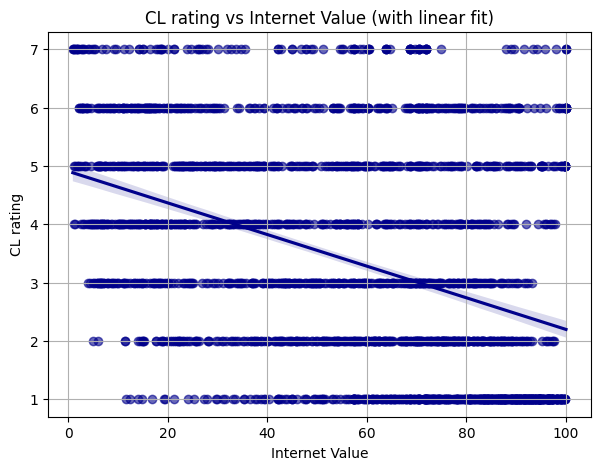

In [119]:
# Scatter plot with regression line
plt.figure(figsize=(7,5))
sns.regplot(x=predictor, y=target, data=data, ci=95, color='darkblue', scatter_kws={'alpha':0.6})
plt.title(f'{target} vs {predictor} (with linear fit)')
plt.grid(True)
plt.show()



Pearson correlation: -0.404


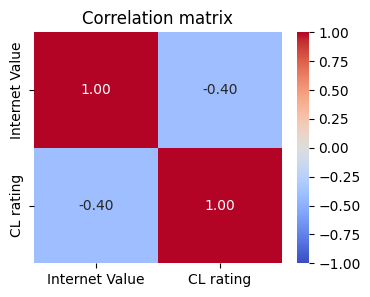

In [120]:
# Pearson correlation
corr = data[predictor].corr(data[target])
print(f'Pearson correlation: {corr:.3f}')

# Correlation heatmap
plt.figure(figsize=(4,3))
sns.heatmap(data[[predictor, target]].corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

##**OLS Regression & Bootstrap CI**

In [121]:
# -------------------------
# OLS Regression
# -------------------------
X = sm.add_constant(data[predictor])
model = sm.OLS(data[target], X).fit(cov_type='HC3')
print(model.summary())

coef = model.params[predictor]
ci_low, ci_high = model.conf_int().loc[predictor]
print(f"\nInterpretation: A one-unit increase in {predictor} is associated with a {coef:.4f} change in {target}. 95% CI: [{ci_low:.4f}, {ci_high:.4f}]")


                            OLS Regression Results                            
Dep. Variable:              CL rating   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     449.3
Date:                Thu, 21 Aug 2025   Prob (F-statistic):           9.99e-91
Time:                        15:19:14   Log-Likelihood:                -4258.1
No. Observations:                2156   AIC:                             8520.
Df Residuals:                    2154   BIC:                             8532.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.9069      0.075     65.

Bootstrap 95% CI: [-0.02959708 -0.02460932]


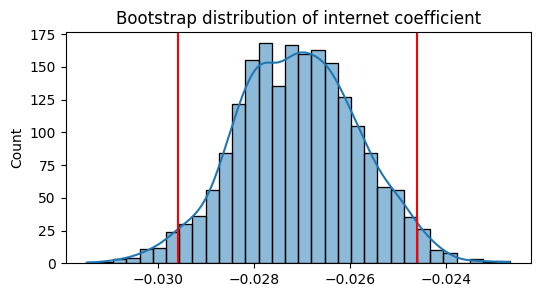

In [122]:
# Bootstrap CI for the coefficient (non-parametric)
rng = np.random.default_rng(123)
B = 2000
coefs = []
xvals = data[predictor].values
yvals = data[target].values
n = len(data)
for _ in range(B):
    idx = rng.integers(0, n, n)
    Xi = sm.add_constant(xvals[idx])
    yi = yvals[idx]
    res = sm.OLS(yi, Xi).fit()
    coefs.append(res.params[1])

ci = np.percentile(coefs, [2.5, 97.5])
print('Bootstrap 95% CI:', ci)

plt.figure(figsize=(6,3))
sns.histplot(coefs, kde=True)
plt.axvline(ci[0], color='red')
plt.axvline(ci[1], color='red')
plt.title('Bootstrap distribution of internet coefficient')
plt.show()

## **Random Forest (predictive) and feature interpretation**
**This gives a predictive perspective and a Partial Dependence Plot (PDP) to show how predicted freedom varies with internet penetration.**


In [123]:
# Random Forest (single predictor for comparison)
X = data[[predictor]]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
print('RF train R^2:', rf.score(X_train, y_train))
print('RF test R^2:', rf.score(X_test, y_test))

# Permutation importance (useful when multiple features; here it'll show contribution)
perm = permutation_importance(rf, X_test, y_test, n_repeats=40, random_state=42)
for i, col in enumerate(X_test.columns):
    print(col, 'permutation importance mean:', perm.importances_mean[i], 'std:', perm.importances_std[i])


RF train R^2: 0.5549591893525765
RF test R^2: 0.05094882796187716
Internet Value permutation importance mean: 0.5085399761018919 std: 0.053982626857785675


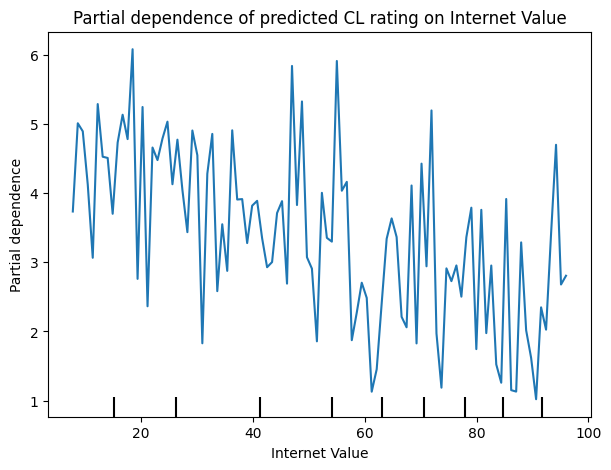

In [124]:
# Partial Dependence Plot
fig, ax = plt.subplots(figsize=(7,5))
PartialDependenceDisplay.from_estimator(rf, X_train, [predictor], ax=ax)
plt.title(f'Partial dependence of predicted {target} on {predictor}')
plt.show()


## **Results summary and interpretation**

In [125]:
# summary
summary = {
    'n': len(data),
    'pearson_corr': corr,
    'ols_coef': coef,
    'ols_pvalue': model.pvalues[predictor],
    'ols_r2': model.rsquared if hasattr(model, 'rsquared') else np.nan,
    'bootstrap_ci_low': ci[0],
    'bootstrap_ci_high': ci[1]
}
summary_df = pd.DataFrame([summary])
#summary_df.to_csv('internet_freedom_summary.csv', index=False)
#print('Saved internet_freedom_summary.csv')
summary_df

,n,pearson_corr,ols_coef,ols_pvalue,ols_r2,bootstrap_ci_low,bootstrap_ci_high
0,2156,-0.403739,-0.027105,1.018482e-99,0.163005,-0.029597,-0.024609


# **2. Does Female Labor Force Participation correlate with Women’s Rights?**

In [126]:
# -------------------------
# 1. Use enriched dataset
# -------------------------
df_exp2 = df_freedom.copy()

# Ensure categorical columns are correct
for col in ['Status', 'Region', 'Country/Territory', 'C/T']:
    if col in df_exp2.columns:
        df_exp2[col] = df_exp2[col].astype('category')

## **Exploratory Data Analysis (EDA)**

In [127]:
# Descriptive statistics
print("\nDescriptive Statistics:")
display(df_exp2[['Female_LFPR', 'G']].describe().T)


Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Female_LFPR,2156.0,56.825320,16.696509,5.13,50.0575,58.91,68.7975,86.72
G,2156.0,9.497217,4.121866,0.00,6.0000,10.00,13.0000,16.00


**Summary Tables - Female Labor Force Participation & Women’s Rights by Status and Region**

In [128]:
# Cross-country averages
lfpr_table = df_exp2.groupby(['Region', 'Status'])['Female_LFPR'].mean().reset_index()
print("=== Female Labor Force Participation by Region and Status ===")
print(lfpr_table)

g_table = df_exp2.groupby(['Region', 'Status'])['G'].mean().reset_index()
print("\n=== Women’s Rights Score (G) by Region and Status ===")
print(g_table)


=== Female Labor Force Participation by Region and Status ===
         Region Status  Female_LFPR
0        Africa      F    51.798774
1        Africa     NF    51.305760
2        Africa     PF    59.021050
3      Americas      F    60.707115
4      Americas     NF    50.732000
5      Americas     PF    54.414486
6          Asia      F    58.910739
7          Asia     NF    63.277957
8          Asia     PF    48.899250
9       Eurasia      F          NaN
10      Eurasia     NF    59.419000
11      Eurasia     PF    64.164423
12       Europe      F    68.468406
13       Europe     NF    38.086667
14       Europe     PF    55.307313
15  Middle East      F    70.011818
16  Middle East     NF    27.679316
17  Middle East     PF    36.834615

=== Women’s Rights Score (G) by Region and Status ===
         Region Status          G
0        Africa      F  10.764151
1        Africa     NF   4.016000
2        Africa     PF   7.222689
3      Americas      F  12.952569
4      Americas     NF   6.12

**Time-Series Plots (2013–2023)**

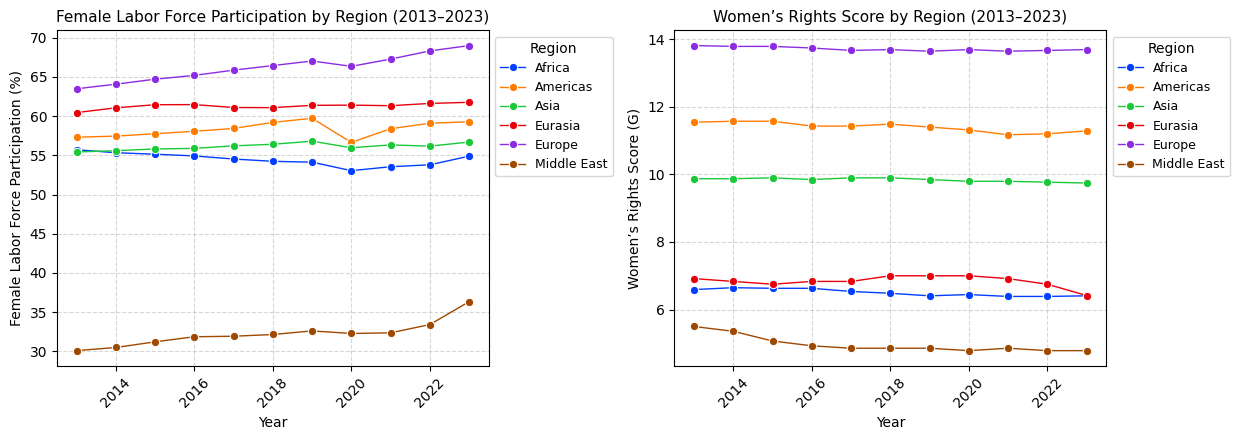

In [129]:
filtered_df = df_exp2.query("2013 <= Edition <= 2023")
palette = sns.color_palette("bright", n_colors=filtered_df['Region'].nunique())

plot_vars = [
    ('Female_LFPR', 'Female Labor Force Participation (%)',
     'Female Labor Force Participation by Region (2013–2023)'),
    ('G', 'Women’s Rights Score (G)',
     'Women’s Rights Score by Region (2013–2023)')
]

fig, axes = plt.subplots(1, 2, figsize=(12.5, 4.5), sharex=True)
for ax, (y_col, y_label, title) in zip(axes, plot_vars):
    sns.lineplot(
        data=filtered_df,
        x='Edition', y=y_col, hue='Region',
        palette=palette, marker='o', linewidth=1, markersize=6,
        errorbar=None, ax=ax
    )
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Region', bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

**Correlation & Partial Correlation Analysis**

In [130]:
num_cols = ['Edition','PR rating','CL rating','G','Female_LFPR']
df_num = df_exp2[num_cols].dropna()
raw_corr = df_num.corr()

def partial_corr_matrix(df):
    variables = df.columns.tolist()
    p_corr = pd.DataFrame(np.eye(len(variables)), index=variables, columns=variables)
    for i, v1 in enumerate(variables):
        for j, v2 in enumerate(variables):
            if i != j:
                covars = [x for x in variables if x not in [v1, v2]]
                result = pg.partial_corr(data=df, x=v1, y=v2, covar=covars)
                p_corr.loc[v1, v2] = result['r'].values[0]
    return p_corr

partial_corr = partial_corr_matrix(df_num)

print("=== Raw Correlation Matrix ===")
display(raw_corr.style.format("{:.2f}"))
print("\n=== Partial Correlation Matrix ===")
display(partial_corr.style.format("{:.2f}"))

=== Raw Correlation Matrix ===


,Edition,PR rating,CL rating,G,Female_LFPR
Edition,1.00,0.04,0.03,-0.02,0.03
PR rating,0.04,1.00,0.94,-0.89,-0.34
CL rating,0.03,0.94,1.00,-0.95,-0.38
G,-0.02,-0.89,-0.95,1.00,0.43
Female_LFPR,0.03,-0.34,-0.38,0.43,1.00



=== Partial Correlation Matrix ===


,Edition,PR rating,CL rating,G,Female_LFPR
Edition,1.00,0.04,0.00,0.03,0.03
PR rating,0.04,1.00,0.66,-0.03,0.08
CL rating,0.00,0.66,1.00,-0.68,0.00
G,0.03,-0.03,-0.68,1.00,0.23
Female_LFPR,0.03,0.08,0.00,0.23,1.00


##**Model Architecture(Mixed Effects Model)**



In [131]:
# Ensure Status is categorical, Edition numeric
df_exp2['Status'] = df_exp2['Status'].astype('category')
df_exp2['Edition'] = pd.to_numeric(df_exp2['Edition'], errors='coerce')

# Average PR and CL
df_exp2['PR_CL_Avg'] = (df_exp2['PR rating'] + df_exp2['CL rating']) / 2

# Mixed-effects model
model_avg = smf.mixedlm(
    "G ~ Female_LFPR * Status + PR_CL_Avg + Edition",
    data=df_exp2,
    groups=df_exp2["Country/Territory"],
    re_formula="1"
)
result_avg = model_avg.fit()
print(result_avg.summary())


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     G         
No. Observations:     2156        Method:                 REML      
No. Groups:           196         Scale:                  0.2332    
Min. group size:      11          Log-Likelihood:         -2071.4597
Max. group size:      11          Converged:              Yes       
Mean group size:      11.0                                          
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                28.932    6.990   4.139 0.000 15.232 42.632
Status[T.NF]             -0.766    0.338  -2.265 0.024 -1.429 -0.103
Status[T.PF]             -0.218    0.279  -0.783 0.434 -0.764  0.328
Female_LFPR               0.017    0.006   2.924 0.003  0.005  0.028
Female_LFPR:Status[T.NF]  0.017    0.006   2.849 0

**Predictions & Residuals**

In [132]:
df_exp2['predicted'] = result_avg.predict(df_exp2)
df_exp2['residual'] = df_exp2['G'] - df_exp2['predicted']

# Variance Inflation Factor (VIF)
X = df_exp2[['Female_LFPR','PR_CL_Avg']].assign(Intercept=1)
vif = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif)


      Variable        VIF
0  Female_LFPR   1.153753
1    PR_CL_Avg   1.153753
2    Intercept  22.555974


**Visualization & Residual Analysis**

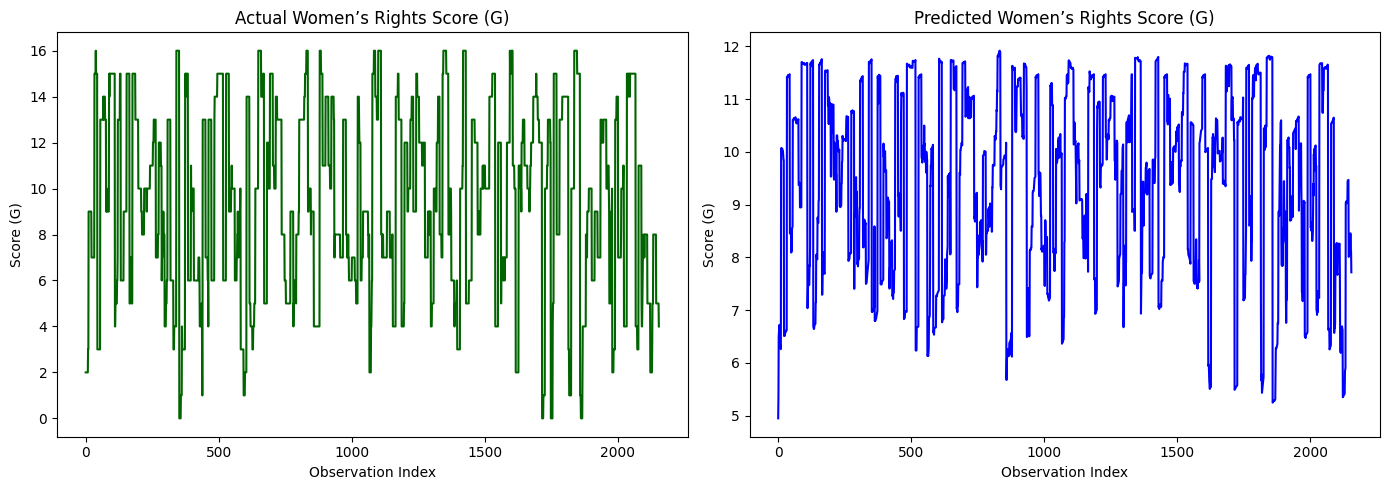

In [133]:
# Actual vs Predicted G scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(df_exp2.index, df_exp2['G'], color='darkgreen')
axes[0].set_title('Actual Women’s Rights Score (G)')
axes[0].set_ylabel('Score (G)')
axes[0].set_xlabel('Observation Index')

axes[1].plot(df_exp2.index, df_exp2['predicted'], color='blue')
axes[1].set_title('Predicted Women’s Rights Score (G)')
axes[1].set_ylabel('Score (G)')
axes[1].set_xlabel('Observation Index')
plt.tight_layout()
plt.show()

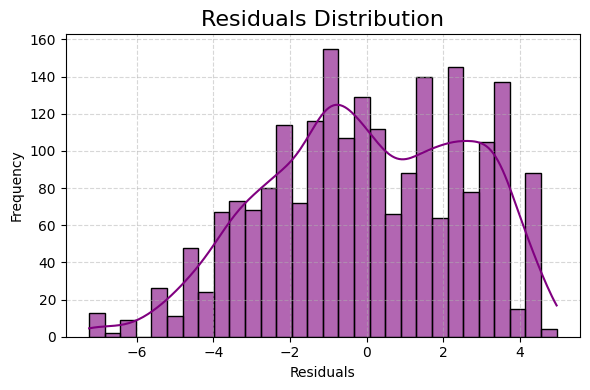

In [134]:
# Residuals Distribution
plt.figure(figsize=(6,4))
sns.histplot(df_exp2['residual'], kde=True, color='purple', bins=30, alpha=0.6)
plt.title('Residuals Distribution', fontsize=16)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

RMSE: 2.5784
MAE: 2.1573


<Figure size 400x400 with 0 Axes>

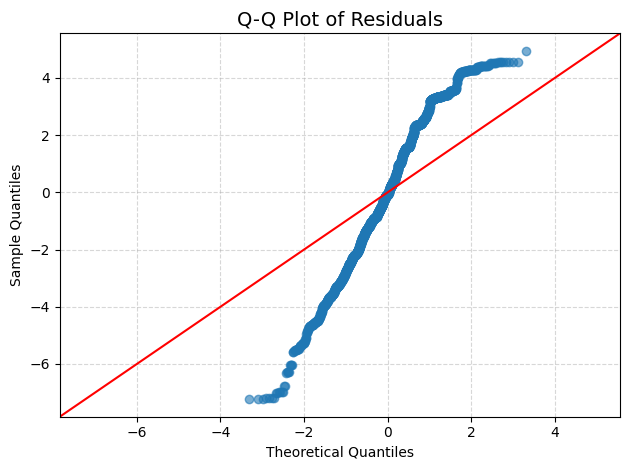

In [135]:

# Error Metrics
rmse = np.sqrt(mean_squared_error(df_exp2['G'], df_exp2['predicted']))
mae = mean_absolute_error(df_exp2['G'], df_exp2['predicted'])
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Q-Q Plot
plt.figure(figsize=(4,4))
sm.qqplot(df_exp2['residual'], line='45', alpha=0.6)
plt.title('Q-Q Plot of Residuals', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Predicted Women’s Rights Score (G) vs Female Labor Force Participation, by Status**

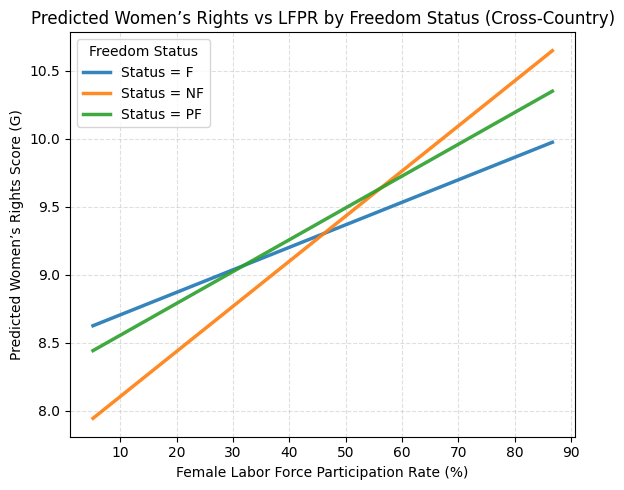

In [136]:
status_levels = df_exp2['Status'].cat.categories
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
female_lfpr_range = np.linspace(df_exp2['Female_LFPR'].min(),
                                df_exp2['Female_LFPR'].max(), 50)

plt.figure(figsize=(6,5))
for i, status in enumerate(status_levels):
    df_pred = pd.DataFrame({
        'Female_LFPR': female_lfpr_range,
        'Status': status,
        'PR_CL_Avg': df_exp2['PR_CL_Avg'].mean(),
        'Edition': df_exp2['Edition'].mode()[0],
        'Country/Territory': df_exp2['Country/Territory'].mode()[0]
    })
    preds = result_avg.predict(df_pred)
    plt.plot(
        female_lfpr_range, preds,
        color=colors[i % len(colors)],
        label=f'Status = {status}',
        linewidth=2.5,
        alpha=0.9
    )

plt.xlabel('Female Labor Force Participation Rate (%)')
plt.ylabel('Predicted Women’s Rights Score (G)')
plt.title('Predicted Women’s Rights vs LFPR by Freedom Status (Cross-Country)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Freedom Status', loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# **3. Do higher Education Levels predict Academic Freedom?**

**Descriptive Statistics**

In [137]:
# -------------------------
# 3.1 Select relevant columns from enriched dataset
# -------------------------
education_df = df_freedom[['Country/Territory','Edition', 'Region', 'Status','PR rating', 'CL rating', 'D3','Tertiary_Enroll_Rate',]].copy()
education_df.rename(columns={'Country/Territory':'Country'}, inplace=True)

print("\nDataset Info:")
education_df.info()

print("\nDescriptive Statistics:")
display(education_df.describe())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Country               2156 non-null   category
 1   Edition               2156 non-null   int64   
 2   Region                2156 non-null   category
 3   Status                2156 non-null   category
 4   PR rating             2156 non-null   int64   
 5   CL rating             2156 non-null   int64   
 6   D3                    2156 non-null   int64   
 7   Tertiary_Enroll_Rate  2156 non-null   float64 
dtypes: category(3), float64(1), int64(4)
memory usage: 98.7 KB

Descriptive Statistics:


,Edition,PR rating,CL rating,D3,Tertiary_Enroll_Rate
count,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000
mean,2018.000000,3.485622,3.363636,2.811224,44.052853
std,3.163011,2.191584,1.906505,1.243856,27.175654
min,2013.000000,1.000000,1.000000,0.000000,0.660000
25%,2015.000000,1.000000,2.000000,2.000000,19.375000
50%,2018.000000,3.000000,3.000000,3.000000,45.155000
75%,2021.000000,6.000000,5.000000,4.000000,61.115000
max,2023.000000,7.000000,7.000000,4.000000,166.670000


**Exploratory Data Analysis (EDA)**

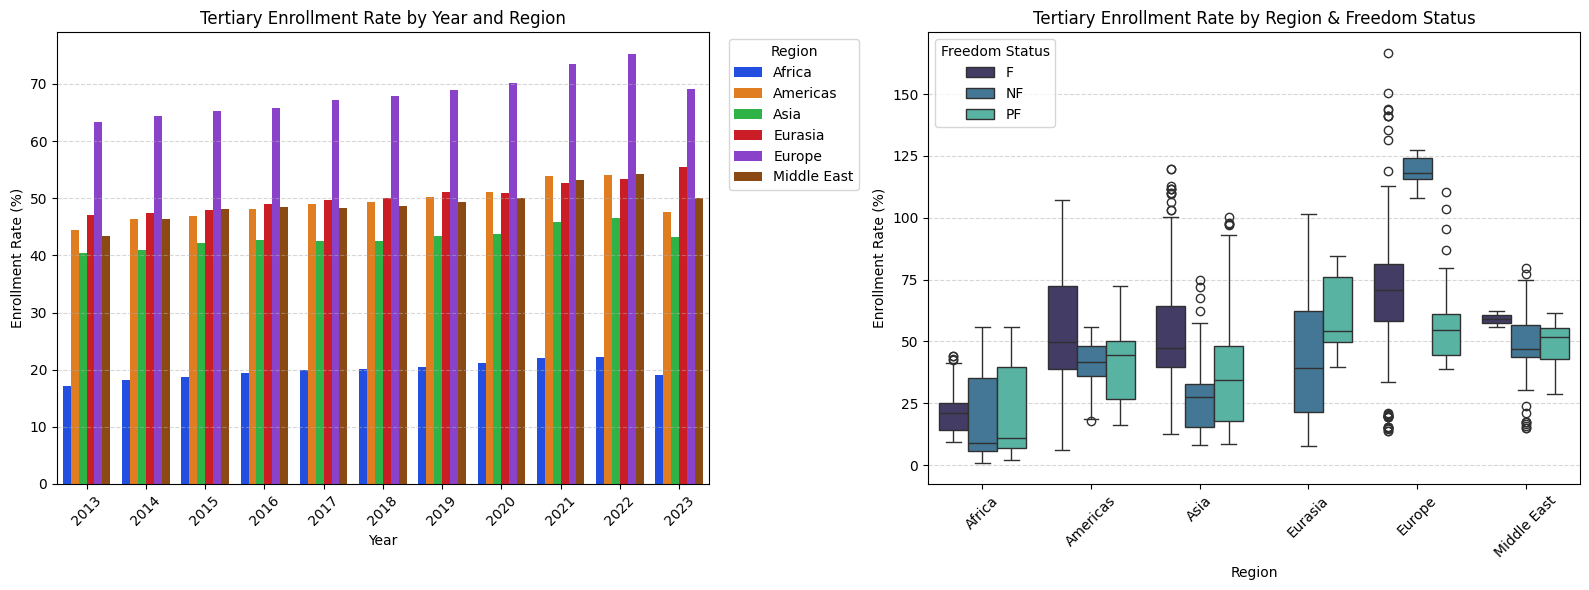

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot: Tertiary Enrollment Rate by Year and Region
sns.barplot(data=education_df, x='Edition', y='Tertiary_Enroll_Rate', hue='Region',
            ci=None, palette='bright', ax=axes[0])
axes[0].set(title='Tertiary Enrollment Rate by Year and Region',
            xlabel='Year', ylabel='Enrollment Rate (%)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Region', loc='upper left', bbox_to_anchor=(1.02, 1))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Box plot: Tertiary Enrollment Rate by Region & Status
sns.boxplot(data=education_df, x='Region', y='Tertiary_Enroll_Rate', hue='Status',
            palette='mako', ax=axes[1])
axes[1].set(title='Tertiary Enrollment Rate by Region & Freedom Status',
            xlabel='Region', ylabel='Enrollment Rate (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Freedom Status', loc='upper left')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()




**Correlation Analysis**




In [139]:
# --- Numeric columns ---
numeric_df = education_df.select_dtypes(include='number')

# --- Raw correlation matrix ---
raw_corr = numeric_df.corr()
print("=== Raw Correlation Matrix ===")
display(raw_corr.style.format("{:.2f}"))

# --- Partial correlation matrix ---
partial_corr_matrix = pg.pcorr(numeric_df)
if {'var1','var2','r'}.issubset(partial_corr_matrix.columns):
    partial_corr_square = partial_corr_matrix.pivot(index='var1', columns='var2', values='r')
    partial_corr_square = partial_corr_square.combine_first(partial_corr_square.T)
else:
    partial_corr_square = partial_corr_matrix

print("\n=== Partial Correlation Matrix ===")
display(partial_corr_square.style.format("{:.2f}"))


=== Raw Correlation Matrix ===


,Edition,PR rating,CL rating,D3,Tertiary_Enroll_Rate
Edition,1.00,0.04,0.03,-0.06,0.07
PR rating,0.04,1.00,0.94,-0.88,-0.42
CL rating,0.03,0.94,1.00,-0.89,-0.44
D3,-0.06,-0.88,-0.89,1.00,0.30
Tertiary_Enroll_Rate,0.07,-0.42,-0.44,0.30,1.00



=== Partial Correlation Matrix ===


,Edition,PR rating,CL rating,D3,Tertiary_Enroll_Rate
Edition,1.00,0.03,-0.02,-0.03,0.09
PR rating,0.03,1.00,0.69,-0.26,-0.08
CL rating,-0.02,0.69,1.00,-0.44,-0.23
D3,-0.03,-0.26,-0.44,1.00,-0.24
Tertiary_Enroll_Rate,0.09,-0.08,-0.23,-0.24,1.00


**Parallel Coordinates Plot**


In [140]:
import plotly.express as px

# --- Parallel Coordinates Plot ---
fig = px.parallel_coordinates(
    education_df,
    dimensions=["Tertiary_Enroll_Rate", "D3", "PR rating", "CL rating"],
    color="PR rating",
    color_continuous_scale=px.colors.sequential.Viridis,
    title="Education Level, Academic Freedom (D3), and Political Ratings"
)

# --- Layout Adjustments to Fix Overlaps ---
fig.update_layout(
    title=dict(
        text="Education Level, Academic Freedom (D3), and Political Ratings",
        x=0.5,
        xanchor='center',
        y=0.95,        # move title slightly up
        yanchor='top'
    ),
    plot_bgcolor='white',
    font=dict(size=12),
    margin=dict(l=80, r=80, t=100, b=80),  # more top margin
    coloraxis_colorbar=dict(
        title='PR Rating',
        titleside='right',
        tickmode='auto',
        ticks='outside',
        showticklabels=True
    )
)

# --- Show Plot ---
fig.show()


**Model Architecture(Regression Model)**



In [141]:
model_df = education_df[['D3','Tertiary_Enroll_Rate','Status','Country','Edition']].copy()
model_df['Status'] = model_df['Status'].astype('category')

# Regression with numeric Edition
linear_model = smf.ols(
    formula="D3 ~ Tertiary_Enroll_Rate * C(Status) + C(Country) + Edition",
    data=model_df
).fit(cov_type='cluster', cov_kwds={'groups': model_df['Country']})

print("\n=== Regression Summary ===")
print(linear_model.summary())



=== Regression Summary ===
                            OLS Regression Results                            
Dep. Variable:                     D3   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     47.69
Date:                Thu, 21 Aug 2025   Prob (F-statistic):           1.01e-35
Time:                        15:19:26   Log-Likelihood:                -190.38
No. Observations:                2156   AIC:                             784.8
Df Residuals:                    1954   BIC:                             1931.
Df Model:                         201                                         
Covariance Type:              cluster                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [142]:
# Coefficients table
coef_df = linear_model.summary2().tables[1]
print("\n=== Coefficients ===")
display(coef_df[['Coef.', 'Std.Err.', 'z', 'P>|z|']])




=== Coefficients ===


,Coef.,Std.Err.,z,P>|z|
Intercept,34.252034,9.466251,3.618332,2.965083e-04
C(Status)[T.NF],-0.564385,0.197852,-2.852555,4.336933e-03
C(Status)[T.PF],-0.139867,0.176224,-0.793686,4.273781e-01
C(Country)[T.Albania],2.005836,0.231179,8.676537,4.080037e-18
C(Country)[T.Algeria],1.327067,0.135769,9.774475,1.449069e-22
...,...,...,...,...
C(Country)[T.Zimbabwe],0.660418,0.041677,15.846120,1.495317e-56
Tertiary_Enroll_Rate,-0.002403,0.002800,-0.858448,3.906449e-01
Tertiary_Enroll_Rate:C(Status)[T.NF],-0.003772,0.003841,-0.982118,3.260419e-01
Tertiary_Enroll_Rate:C(Status)[T.PF],-0.004112,0.004157,-0.989216,3.225574e-01


**Interaction Effect Interpretation**

In [143]:
coef_enroll = linear_model.params.get('Tertiary_Enroll_Rate', None)
coef_interaction_pf = linear_model.params.get('Tertiary_Enroll_Rate:C(Status)[T.PF]', 0)
coef_interaction_nf = linear_model.params.get('Tertiary_Enroll_Rate:C(Status)[T.NF]', 0)

print("\nInterpretation of Interaction Effect:")
if coef_enroll is not None:
    effect_free = coef_enroll
    effect_pf = coef_enroll + coef_interaction_pf
    effect_nf = coef_enroll + coef_interaction_nf

    print(f"Effect of Tertiary Enrollment Rate on D3 for Status=Free: {effect_free:.4f}")
    print(f"Effect of Tertiary Enrollment Rate on D3 for Status=Partially Free: {effect_pf:.4f}")
    print(f"Effect of Tertiary Enrollment Rate on D3 for Status=Not Free: {effect_nf:.4f}")
else:
    print("Tertiary Enrollment Rate coefficient not found in the model.")


Interpretation of Interaction Effect:
Effect of Tertiary Enrollment Rate on D3 for Status=Free: -0.0024
Effect of Tertiary Enrollment Rate on D3 for Status=Partially Free: -0.0065
Effect of Tertiary Enrollment Rate on D3 for Status=Not Free: -0.0062


**Predicted Academic Freedom(D3) vs Enrollment Rate**

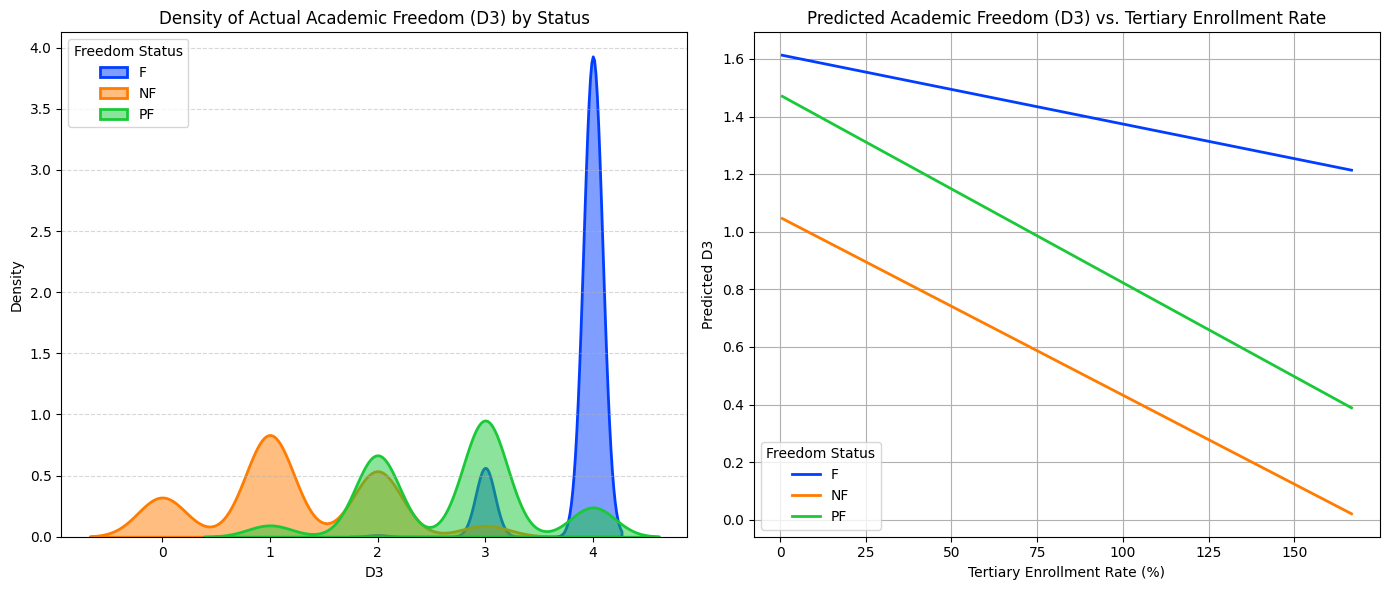

In [144]:
enroll_range = np.linspace(model_df['Tertiary_Enroll_Rate'].min(),
                           model_df['Tertiary_Enroll_Rate'].max(), 50)

predict_df = pd.DataFrame()
for status in model_df['Status'].cat.categories:
    df_temp = pd.DataFrame({
        'Tertiary_Enroll_Rate': enroll_range,
        'Status': status,
        'Country': model_df['Country'].mode()[0],
        'Edition': model_df['Edition'].mode()[0]
    })
    df_temp['D3_pred'] = linear_model.predict(df_temp)
    predict_df = pd.concat([predict_df, df_temp], ignore_index=True)

# Plot actual vs predicted
colors = sns.color_palette('bright', n_colors=len(model_df['Status'].cat.categories))
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Left: Actual D3 density
for i, status in enumerate(model_df['Status'].cat.categories):
    subset = model_df[model_df['Status'] == status]
    sns.kdeplot(subset['D3'], fill=True, alpha=0.5, linewidth=2,
                label=status, color=colors[i], ax=axes[0])
axes[0].set(title='Density of Actual Academic Freedom (D3) by Status',
            xlabel='D3', ylabel='Density')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)
axes[0].legend(title='Freedom Status', loc='upper left')

# Right: Predicted D3 vs Tertiary Enrollment Rate
for i, status in enumerate(model_df['Status'].cat.categories):
    subset_pred = predict_df[predict_df['Status'] == status]
    axes[1].plot(subset_pred['Tertiary_Enroll_Rate'], subset_pred['D3_pred'],
                 color=colors[i], linewidth=2, label=status)
axes[1].set(title='Predicted Academic Freedom (D3) vs. Tertiary Enrollment Rate',
            xlabel='Tertiary Enrollment Rate (%)', ylabel='Predicted D3')
axes[1].legend(title='Freedom Status', loc='lower left')
axes[1].grid(True)

plt.tight_layout()
plt.show()
